In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from utils import create_features

In [24]:
model = joblib.load('../models/xgb_model.joblib')

In [25]:
def simulate_future_returns(df, model, future_days=365, init_cash=1000, hist_vol=None):
    df = df.copy()
    last_rows = df.iloc[-26:].copy()  # keep enough history for indicators
    portfolio = [init_cash]
    cash = init_cash
    future_preds = []

    if hist_vol is None:
        hist_vol = df['Close'].pct_change().std()

    for _ in range(future_days):
        # Recompute all features based on last_rows
        features_df, feature_cols = create_features(last_rows, for_simulation=True)
        if features_df.empty:
            print("last_rows used in create_features:")
            print(last_rows)
            raise ValueError("features_df is empty, cannot predict.")

        X_input = features_df.iloc[[-1]][feature_cols]

        pred_return = model.predict(X_input)[0]
        pred_return = np.random.normal(pred_return, hist_vol)
        future_preds.append(pred_return)

        # Simulate next OHLC
        next_close = last_rows['Close'].iloc[-1] * (1 + pred_return)
        next_open = next_close
        next_high = next_close * 1.01
        next_low = next_close * 0.99
        next_volume = last_rows['Volume'].iloc[-1]  # keep same volume or add noise

        new_row = pd.DataFrame({
            'Open':[next_open],
            'High':[next_high],
            'Low':[next_low],
            'Close':[next_close],
            'Volume':[next_volume]
        })

        last_rows = pd.concat([last_rows, new_row], ignore_index=True).iloc[-26:]  # maintain rolling history
        cash = cash * (1 + pred_return)
        portfolio.append(cash)

    return future_preds, portfolio

In [26]:
def monte_carlo_simulation(filtered_df, model, future_days=365, init_cash=1000, n_sims=100):
    """
    Run many simulations to capture uncertainty in predictions.
    Returns all portfolio trajectories and final values.
    """
    all_trajectories = []
    hist_vol = filtered_df['Close'].pct_change().std()

    for _ in range(n_sims):
        _, portfolio = simulate_future_returns(
            filtered_df,
            model,
            future_days=future_days,
            init_cash=init_cash,
            hist_vol=hist_vol
        )
        all_trajectories.append(portfolio)

    return np.array(all_trajectories)

In [27]:
def visualize_all_paths(all_trajectories, init_cash=1000):
    plt.figure(figsize=(12,6))
    for path in all_trajectories:
        plt.plot(path, color="blue", alpha=0.05)  # faint blue lines

    plt.plot(all_trajectories.mean(axis=0), color="black", linewidth=2, label="Mean Path")
    plt.title("Monte Carlo Simulation of Portfolio Paths")
    plt.xlabel("Days")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.grid(True)
    plt.show()

In [29]:
filtered_df = pd.read_csv("../data/SOL-USD-filtered.csv")

# Run Monte Carlo
n_sims = 100
all_trajectories = monte_carlo_simulation(
    filtered_df, model, future_days=60, init_cash=1000, n_sims=n_sims
)

# Distribution at final day
final_values = all_trajectories[:,-1]
print("Mean final portfolio:", final_values.mean())
print("5th percentile (pessimistic):", np.percentile(final_values, 5))
print("95th percentile (optimistic):", np.percentile(final_values, 95))

/Users/janhaslik/Code/xgboost_solana/utils.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill().fillna(0)
/Users/janhaslik/Code/xgboost_solana/utils.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill().fillna(0)
/Users/janhaslik/Code/xgboost_solana/utils.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  

Mean final portfolio: 1530.8542894949576
5th percentile (pessimistic): 476.7227996503398
95th percentile (optimistic): 3672.9032690694667


/Users/janhaslik/Code/xgboost_solana/utils.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill().fillna(0)
/Users/janhaslik/Code/xgboost_solana/utils.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill().fillna(0)
/Users/janhaslik/Code/xgboost_solana/utils.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  

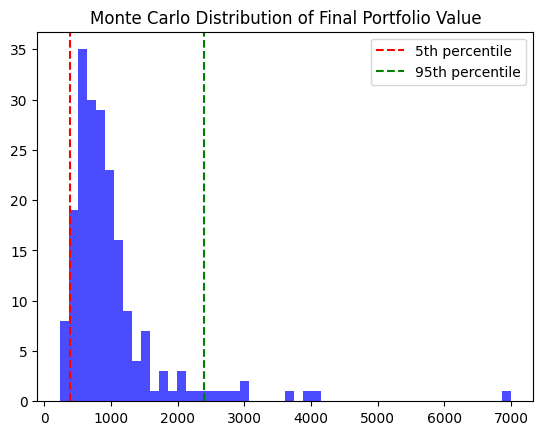

In [16]:
plt.hist(final_values, bins=50, alpha=0.7, color='blue')
plt.axvline(np.percentile(final_values, 5), color='red', linestyle='--', label="5th percentile")
plt.axvline(np.percentile(final_values, 95), color='green', linestyle='--', label="95th percentile")
plt.title("Monte Carlo Distribution of Final Portfolio Value")
plt.legend()
plt.show()

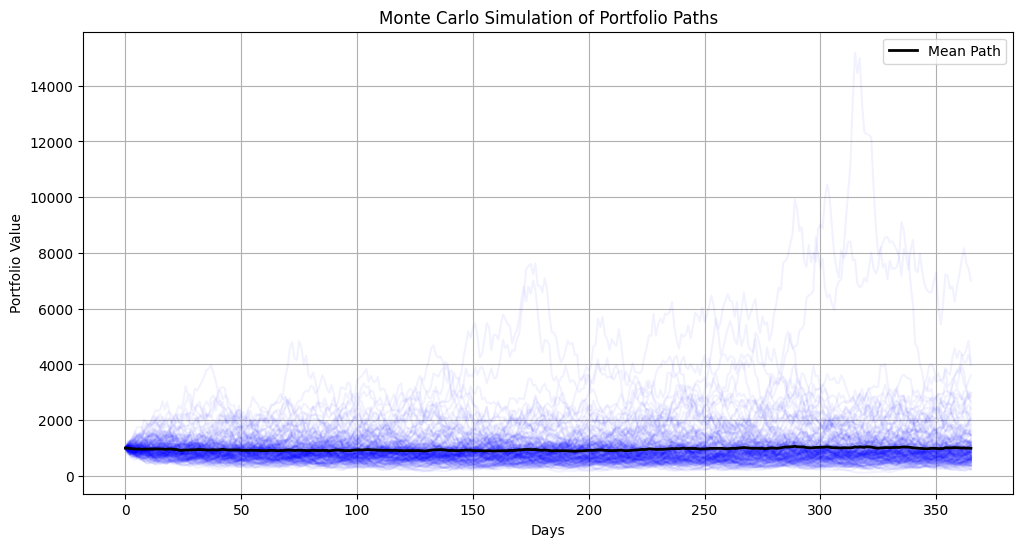

In [17]:
visualize_all_paths(all_trajectories, init_cash=1000)